In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from scipy.stats import levy_stable
import scipy

# Langevin Monte Carlo

New samples are proposed by simulating the Langevin Stochastic Differential Equation (SDE) which is given by

$$dX_t = -\nabla U(X_t)dt + \sqrt{2}dB_t$$

where $U$ is the potential function and $B_t$ is the standard Brownian motion.

### Example
Let $U(\mathbf{z}) = \frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^2 - \log\left(e^{-0.5\left[\frac{\mathbf{z}_1 - 2}{0.6}\right]} + e^{-0.5\left[\frac{\mathbf{z}_1 + 2}{0.6}\right]}\right)$, and $p(\mathbf{z}) \propto e^{-U(\mathbf{z})}$ be the distribution we want to sample from.

Let's visualize the (unnormalized) density.

In [2]:
def npdensity1(z):
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

def npdensity2(z):
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return np.exp(-u)

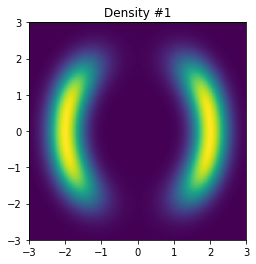

In [3]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity1(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Density #1')
plt.show()

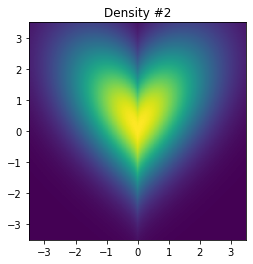

In [4]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity2(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Density #2')
plt.show()

## Unadjusted Langevin Algorithm (ULA)

The Langevin SDE can be simulated using the Euler-Maruyama scheme as follows

$$X_{k+1} = X_{k} - \gamma_{k+1}\nabla U(X_k) + \sqrt{2\gamma_{k+1}}Z_{k+1}$$

where $\gamma_{k+1}$ is the step size and $Z_{k+1}$ is a sample from $\mathcal{N}(0, I)$ respectively at the $k+1$-th time-step.

In practice, there are various tricks to set $\gamma_{k+1}$ and $X_0$, the initial seed. However, in the following examples, I've used a constant step-size and have sampled $X_0$ from $\mathcal{N}(0, I)$.

The above simulation of Langevin dynamics can be used to draw samples from densities of the form $p(x) = \frac{e^{-U(x)}}{Z}$ where Z may or may not be known. It is assumed that the gradient of $U$ is $L$-Lipschtiz.

In [5]:
def potential1(z):
    z = z.view(-1, 2).double()
    z1, z2 = z[:, 0], z[:, 1]
    norm = torch.norm(z, p=2, dim=1)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return u

def potential2(z):
    z = z.view(-1, 2).double()
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return u

def density1(z):

    return torch.exp(-potential1(z))

def density2(z):

    return torch.exp(-potential2(z))

fractional differentiation : $
\mathcal{D}^{\gamma} f(x) \triangleq \mathcal{F}^{-1}\left\{\mid \omega |^{\gamma} \hat{f}(\omega)\right\}
$

In [6]:

def fractional_diff(func, gamma, Z):

    result = func(Z).detach().numpy()
    norm = torch.norm(Z).detach().numpy()

    res = np.fft.irfft2(norm ** gamma * np.fft.rfft2(result), s=Z.shape)
    return torch.from_numpy(res).double()

$
f_{\pi}(x) \triangleq-\phi(x) \partial_{x} U(x)
$

In [7]:
def f_pi(Z, potential, density):
    Z.requires_grad_()
    U = potential(Z)
    grad = torch.autograd.grad(U, Z)[0]
    return - density(Z) * grad

In [48]:
def fractional_LMC(potential, density, alpha=1.7, n_samples=50000, steps=0.1, dim=2):
    burn_in = 10000
    Z0 = torch.randn(1, dim).double()

    Zi = Z0
    samples = []

    random_vars = levy_stable.rvs(alpha, beta=0, size=dim * (n_samples + burn_in))
    random_vars = torch.from_numpy(random_vars.reshape((random_vars.shape[0] // dim, dim)))


    for i in tqdm(range(n_samples + burn_in)):
        f_pi_ = lambda Z: f_pi(Z, potential, density)
        diff_f = fractional_diff(f_pi_, alpha-2, Zi)
        b = diff_f / (density(Zi) + 1e-20)

        Zi = Zi.detach() + steps * b + steps ** (1/alpha) * random_vars[i]
        samples.append(Zi.detach().numpy())


    return np.concatenate(samples, 0)[burn_in:]

Run the ULA and render the empirical density.

In [132]:
# not working properly when alpha < 2
samples1 = fractional_LMC(potential1, density1, n_samples =5000, alpha=1.7, steps=0.0003)
samples2 = fractional_LMC(potential2, density2, n_samples =5000, alpha=1.7, steps=0.0003)

/var/folders/57/s8ftltw13n1dfhbmr5fqsggw0000gn/T/ipykernel_888/3031163158.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_samples + burn_in)):


  0%|          | 0/10000 [00:00<?, ?it/s]

In [136]:
indices = ~np.logical_or(np.isnan(samples1)[:, 0], np.isnan(samples1)[:, 1])
samples1 = samples1[indices]

indices = ~np.logical_or(np.isnan(samples2)[:, 0], np.isnan(samples2)[:, 1])
samples2 = samples2[indices]

In [137]:
for i in range(0, len(samples1), 100):
    print(samples1[i]) # need be between -4 and 4

[ 3.20122466 -1.18834123]
[ 3.35660742 -1.24561692]
[ 3.13618464 -1.11218275]
[ 2.97476035 -1.24869519]
[ 3.15765664 -1.43948644]
[ 3.05561651 -1.50967624]
[ 2.94602139 -1.42010115]
[ 3.4143152  -1.23826068]
[ 3.10391676 -1.1607033 ]
[ 3.05336943 -1.34190086]
[ 2.96795424 -1.30620171]
[ 2.91365221 -1.27914464]
[ 2.56739684 -1.27569919]
[ 2.67738649 -1.4909681 ]
[ 2.94504763 -1.4996525 ]
[ 3.26470237 -1.11469299]
[ 3.30381613 -0.84792571]
[ 3.83853951 -0.90533401]
[ 4.05692748 -0.93078007]
[ 4.09202979 -0.96899028]
[ 4.05972605 -0.97657569]
[ 4.10774539 -1.01963713]
[ 4.06398197 -1.01096337]
[ 3.72193174 -0.83546121]
[ 3.83711923 -0.70782416]
[ 3.75848129 -0.77359652]
[ 3.65846011 -1.01180131]
[ 3.61634695 -1.45457919]
[ 3.55545555 -1.26719254]
[ 3.55835437 -1.61395591]
[ 3.52110389 -1.44827725]
[ 3.46379637 -1.25022717]
[ 3.50557795 -1.06236811]
[ 3.71962856 -1.10357616]
[ 3.82838147 -0.87206495]
[ 3.75485862 -0.91493044]
[ 3.84357399 -0.91996497]
[ 3.89940783 -0.93373535]
[ 3.24009095

In [138]:
samples1.shape, samples2.shape

((5000, 2), (5000, 2))

In [ ]:
# not stable
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Empirical Density #1')
plt.show()

In [ ]:
# not stable
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim([-3.5, 3.5])
# plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

## Experiemnt on paper

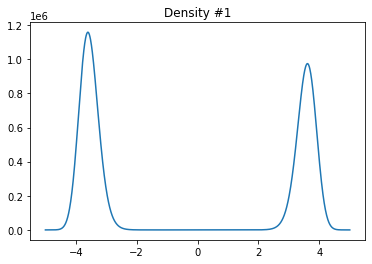

In [33]:


def npdensity3(x):
    assert(type(x) == float or type(x) == np.ndarray)
    u = (x+5) * (x+1) * (x-1.02) * (x-5) / 10 + 0.5
    return np.exp(-u)

x = np.linspace(-5, 5, 1000)

y = npdensity3(x)
plt.plot(x, y)
plt.title('Density #1')
plt.show()

In [34]:
def potential3(x):
    u = (x+5) * (x+1) * (x-1.02) * (x-5) / 10 + 0.5
    return u

def density3(x):
    return torch.exp(-potential3(x))

In [113]:
samples1 = fractional_LMC(potential3, density3, alpha=1.7, step=0.01, dim=1)
samples2 = fractional_LMC(potential3, density3, alpha=2, step=0.01, dim=1)

/var/folders/57/s8ftltw13n1dfhbmr5fqsggw0000gn/T/ipykernel_888/3031163158.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_samples + burn_in)):


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
for i in range(0, len(samples1), 100):
    print(samples1[i]) # need to be between -4 and 4

[-3.42913829]
[-3.42461189]
[-3.47924757]
[-3.42190594]
[-3.44224459]
[-3.51170295]
[-3.51850384]
[-3.35934887]
[-3.2524349]
[-3.1493122]
[-3.13737905]
[-3.10267072]
[-3.24679536]
[-3.26783651]
[-3.21345381]
[-3.26395589]
[-3.23617477]
[-3.30027341]
[-3.35315349]
[-3.3515511]
[-3.25618828]
[-3.12741885]
[-3.09824415]
[-2.95948806]
[-3.47197186]
[-3.46136603]
[-3.59156207]
[-3.47054329]
[-3.52415233]
[-3.47459189]
[-3.54748388]
[-3.65719035]
[-3.69821466]
[-3.60679107]
[-3.65489845]
[-3.64805144]
[-3.70949529]
[-3.78697556]
[-3.68983508]
[-3.75574686]
[-3.53098965]
[-3.70540247]
[-3.79372703]
[-3.88354229]
[-3.79531014]
[-3.80658963]
[-3.78700565]
[-3.67605764]
[-3.71760183]
[-3.72959854]
[-3.73808093]
[-3.6268381]
[-3.41177308]
[-3.33463301]
[-3.35764018]
[-3.41610483]
[-3.33559137]
[-3.32046582]
[-3.18463384]
[-3.26476639]
[-3.25242158]
[-3.27304627]
[-3.24051993]
[-3.18033505]
[-3.11575762]
[-3.23931301]
[-3.21866896]
[-3.35851131]
[-3.18957034]
[-3.4294554]
[-3.47939134]
[-3.5428786

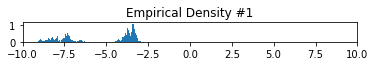

In [38]:
plt.hist(samples1, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-10, 10)
plt.title('Empirical Density #1')
plt.show()

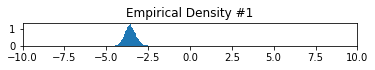

In [39]:
plt.hist(samples2, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-10, 10)
plt.title('Empirical Density #1')
plt.show()

## Numerical approximation

In [102]:
from scipy.special import gamma as gamma_func
def g(gamma, k):
    return (-1) ** k * gamma_func(gamma + 1) / ((gamma_func(gamma/2 - k + 1)) * (gamma_func(gamma/2 + k + 1)))

def fractional_centered_difference(f, x, gamma, h, K):
    sum = 0
    for k in range(-K, K+1):
        sum += g(gamma, k) * f(x - k * h)
    return sum

def tilde_b(f_pi_, h, K, x, alpha, density):
    # alpha-2 -> 0
    return fractional_centered_difference(f_pi_, x, 0, h, K) / density(x)

def fractional_approx_LMC(potential, density, alpha=1.7, n_samples=5000, steps=0.01, dim=2):
    burn_in = 5000
    Z0 = torch.randn(1, dim).double()

    if type(steps) is float:
        steps = [steps] * (n_samples + burn_in)

    Zi = Z0
    samples = []

    random_vars = levy_stable.rvs(alpha, 0, size=dim * (n_samples + burn_in))
    random_vars = torch.from_numpy(random_vars.reshape((random_vars.shape[0] // dim, dim)))


    for i in tqdm(range(n_samples + burn_in)):
        f_pi_ = lambda Z: f_pi(Z, potential, density)
        b = tilde_b(f_pi_, h=0.06, K=15, x=Zi, alpha=alpha, density=density3)

        Zi = Zi.detach() + steps[i] * b + steps[i] ** (1./alpha) * random_vars[i]
        samples.append(Zi.detach().numpy())


    return np.concatenate(samples, 0)[burn_in:]

In [106]:
# takes about 5 min
steps = [(1e-3 / n) ** 0.6 for n in range(1, 20000)]
samples1 = fractional_approx_LMC(potential3, density3, alpha=1.7, steps=0.01, dim=1)
samples2 = fractional_approx_LMC(potential3, density3, alpha=2, steps=0.01, dim=1)

/var/folders/57/s8ftltw13n1dfhbmr5fqsggw0000gn/T/ipykernel_888/3031163158.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_samples + burn_in)):


  0%|          | 0/10000 [00:00<?, ?it/s]

In [111]:
for i in range(0, len(samples1), 100):
    print(samples1[i]) # need to be between -10 and 10

-3.3108498546549425
-2.991759007544115
-3.6496529269933258
-3.448360893145737
-3.4799015392111805
3.2217393160003267
3.897703859027752
3.6004952098149348
3.784795978926524
3.214740803138554
3.947507074869684
2.9930164567195354
3.5802346309238082
3.489477104175167
3.6378244904873154
3.3495950617748687
3.904802777583802
3.2325649304890285
3.5679330876801147
3.6909256080710366
3.0315805946499084
3.136744063443552
3.657541958301413
2.370120437229639
3.763497635298381
3.381471693869927
3.638136156504764
3.708347044231932
-3.7451499897359435
-3.426035368184626
-3.4725395894753492
-4.011020735212612
-3.5765276842598768
-3.551204447731226
-3.5982058988324406
-3.8801830951671454
-4.702524746204109
-3.620944809027305
-3.909443419371626
-2.680089747301568
-4.115937548579616
-3.676585134423211
-3.783519797874825
-3.336927843730773


In [108]:
samples1 = samples1[~np.isnan(samples1)]
samples2 = samples2[~np.isnan(samples2)]

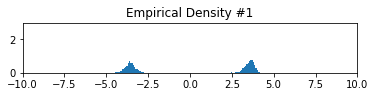

In [109]:
plt.hist(samples1, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-10, 10)
plt.ylim(0, 3)
plt.title('Empirical Density #1')
plt.show()

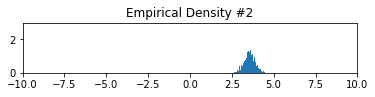

In [110]:
plt.hist(samples2, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-10, 10)
plt.ylim(0, 3)
plt.title('Empirical Density #2')
plt.show()